# Author prediction using RNNs

In this notebook, you will prepare a dataset to predict authorship of the Federalist Papers using Recurrent Neural Networks (RNNs).

## Federalist Papers

The Federalist Papers are a collection of 85 articles and essays written by Alexander Hamilton, James Madison, and John Jay under the pseudonym "Publius". They were published in 1787 and 1788 to promote the ratification of the United States Constitution. The authors of the Federalist Papers wanted to remain anonymous, so they used the pseudonym "Publius". The articles were published in two newspapers, the New York Packet and the Independent Journal. The Federalist Papers are considered important works of American political thought and are still widely read today.

## Additional information

- [Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers)
- [Federalist Papers dataset](https://www.kaggle.com/datasets/tobyanderson/federalist-papers)
- [LOC Research Guide](https://guides.loc.gov/federalist-papers/full-text)

## Objectives (a)

- Task 1: Design your dataset to predict the author of a text using RNNs.
- Task 2: Explain the methodology of your dataset creation.
- Task 3: Establish a baseline model using Machine Learning algorithms (SVM, Random Forest, etc.).
  
## Objectives (b)

- Task 4: Train a RNN model to predict the author of a text.
- Task 5: Evaluate the performance of your model.
- Task 6: Explain your model architecture, hyperparameters, and the results of your model.

## Task 1: Dataset Creation

### Dataset description

Use the below code to scrape the Library of Congress research guide for the Federalist Papers. You need to pip install the following for the below code to work:

- `pip install beautifulsoup4`
- `pip install requests`
- `pip install pandas`

In [18]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests

url = 'https://guides.loc.gov/federalist-papers/full-text'

html = requests.get(url).text
soup = bs(html, 'html.parser')

# convert the html table to a pandas dataframe
table = soup.find('table')

# List of Federalist Papers
meta_df = pd.read_html(StringIO(str(table)), parse_dates=True)[0]

### Dataset datatypes

In [19]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No.          85 non-null     float64
 1   Title        85 non-null     object 
 2   Author       85 non-null     object 
 3   Publication  85 non-null     object 
 4   Date         85 non-null     object 
dtypes: float64(1), object(4)
memory usage: 3.4+ KB


In [20]:
meta_df.head()

,No.,Title,Author,Publication,Date
0,1.0,General Introduction,Hamilton,For the Independent Journal,--
1,2.0,Concerning Dangers from Foreign Force and Infl...,Jay,For the Independent Journal,--
2,3.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--
3,4.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--
4,5.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--


### Autorship counts

Plot the count the number of papers written by each author. We want to create a machine learning dataset that consists of a train, validation, and test set. We will use the train set to train the model, the validation set to tune the hyperparameters, and the test set to evaluate the model.

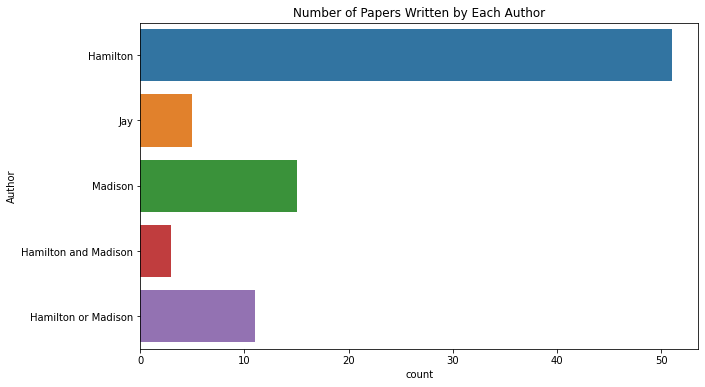

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot the number of papers written by each author
plt.figure(figsize=(10, 6))
sns.countplot(y='Author', data=meta_df)
plt.title('Number of Papers Written by Each Author')
plt.show()

In [22]:
# Group by author and count the number of papers
papers_per_author = meta_df.groupby('Author')['No.'].count().reset_index()
papers_per_author.columns = ['Author', 'Number of Papers']
print(papers_per_author)


                 Author  Number of Papers
0              Hamilton                51
1  Hamilton and Madison                 3
2   Hamilton or Madison                11
3                   Jay                 5
4               Madison                15


Based on the data, answer the following questions:

- How many papers were written by each author?
- How should you construct your dataset? Explain your reasoning.

Hamilton wrote 51, Jay wrote 5 and Madison wrote 15. There are 3 papers that are written together by Hamilton and Madison. There are 11 papers that seem to be written by either Hamilton or Madison.

To analyze and determine the authorship of the disputed papers, we will separate 

### Contested authorship

In [23]:
# disputed papers
disputed_papers = meta_df[meta_df['Author'] == 'Hamilton or Madison']
contested_authorship = disputed_papers['No.'].values
print(f'Contested authorship of papers: {contested_authorship}')
print(f'Total number of disputed papers: {len(disputed_papers)}')

Contested authorship of papers: [49. 50. 51. 52. 53. 54. 55. 56. 57. 62. 63.]
Total number of disputed papers: 11


### Load the Federalist Papers corpus

The following code loads the Federalist Papers corpus. The papers have been preprocessed to aid your analysis of the authorship of the papers.

In [24]:
corpus = pd.read_pickle('fp_corpus.pkl')
corpus.head()

,text,paper_id,target,sentences,sentence_length,sentence_index,total_sentences
0,Method of Guarding Against the Encroachments o...,49,dispt,Method of Guarding Against the Encroachments o...,25,0,63
0,Method of Guarding Against the Encroachments o...,49,dispt,"Tuesday, February 5, 1788.",4,1,63
0,Method of Guarding Against the Encroachments o...,49,dispt,Author: Alexander Hamilton or James Madison,6,2,63
0,Method of Guarding Against the Encroachments o...,49,dispt,To the People of the State of New York:,9,3,63
0,Method of Guarding Against the Encroachments o...,49,dispt,"THE author of the ""Notes on the State of Virgi...",56,4,63


The above datasets contains the following columns:

- `paper_id`: The ID of the paper. This corresponds to the number of the paper in the Federalist Papers collection.
- `author`: The author of the paper. This can be one of three values: `Hamilton`, `Madison`, `Jay`, `dispt` (disputed), and `HM` (Hamilton and Madison).
- `text`: The text of the paper.
- `sentence_length`: The token count of the sentence, defined as the number of tokens by splitting the sentence by spaces.
- `sentence_index`: The index of the sentence in the paper.
- `total_sentences`: The total number of sentences in the paper.

The sentences were created by using the Spacy transformer library to split the text of papers into sentences.

In [25]:
# drop the duplicates and keep target and paper_id
authorship = corpus.drop_duplicates(subset=['paper_id', 'target'])
authorship.target.value_counts()

Hamilton    51
Madison     15
dispt       11
Jay          5
HM           3
Name: target, dtype: int64

### Dataset creation

Your task is to predict the author of a paper using the text of the paper. You will use a Recurrent Neural Network (RNN) to predict the author of a paper. You will use the Federalist Papers dataset to train and evaluate your model.

In [26]:
# YOUR CODE HERE - CREATE A DATASET FOR THE CLASSIFICATION TASK OF AUTHORSHIP ATTRIBUTION
corpus = pd.read_pickle('fp_corpus.pkl')

# disputed author dataset 
disputed = authorship[authorship['target'] == 'dispt']

# non-disputed authors
non_disputed = authorship[authorship['target'] != 'dispt']

### Plot the distribution of the number of papers written by each author.

In [27]:
# YOUR CODE HERE - Visualize the distribution of the sentence lengths (what is the quartile distribution of the sentence lengths?)


### Plot the distribution of sentence lengths for each author.

In [28]:
# YOUR CODE HERE - Visualize the distribution of sentence lengths according to the authorship


### Prepare dataset for training

Prepare a training, validation, and test dataset. What is your X and y? What is the size of your training, validation, and test dataset?

In [29]:
from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(
    corpus['text'], corpus['target'], test_size=0.2, random_state=404)
print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(x_val)}')

Training samples: 4887
Validation samples: 1222


#### Visualize some random samples

In [30]:
import random

# sample a random sentence from the training set
random_idx = random.randint(0, len(X_train))
print(f'Random sentence: {X_train.iloc[random_idx]}')
print(f'Author: {y_train.iloc[random_idx]}')

Random sentence: The Provision For The Support of the Executive, and the Veto Power From the New York Packet Friday, March 21, 1788. Author: Alexander Hamilton To the People of the State of New York: THE third ingredient towards constituting the vigor of the executive authority, is an adequate provision for its support. It is evident that, without proper attention to this article, the separation of the executive from the legislative department would be merely nominal and nugatory. The legislature, with a discretionary power over the salary and emoluments of the Chief Magistrate, could render him as obsequious to their will as they might think proper to make him. They might, in most cases, either reduce him by famine, or tempt him by largesses, to surrender at discretion his judgment to their inclinations. These expressions, taken in all the latitude of the terms, would no doubt convey more than is intended. There are men who could neither be distressed nor won into a sacrifice of their

#### Plot the distribution of training and validation samples

Have you split the dataset in a stratified manner? Explain why it is important to split the dataset in a stratified manner. If you have not, explain why you did not split the dataset in a stratified manner. See the documentation for [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more information.

#### Plot the datasets

c:\Users\Yera\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Yera\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


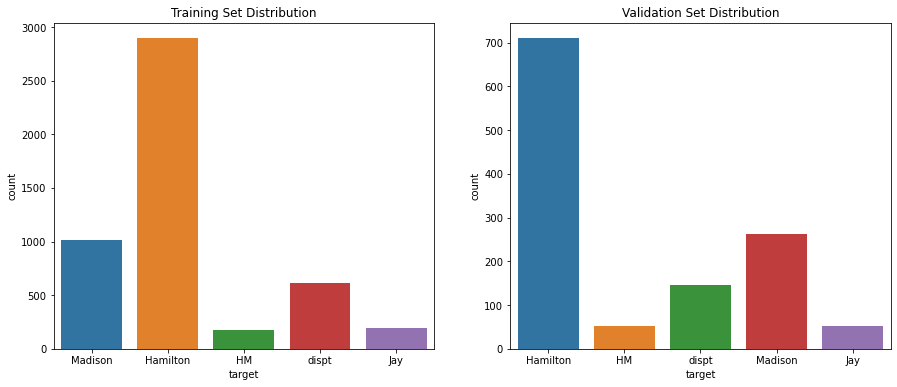

In [31]:
# plot the distribution of the target classes in the training and validation set on a countplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# first plot is the training set
sns.countplot(y_train, ax=ax[0])
ax[0].set_title('Training Set Distribution')
# second plot is the validation set
sns.countplot(y_val, ax=ax[1])
ax[1].set_title('Validation Set Distribution')
plt.show()

#### Convert the target labels to one hot encodings

In [36]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_val_ohe = ohe.transform(y_val.values.reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (4887, 5)
One hot encoded validation labels shape: (1222, 5)


In [37]:
y_train_ohe[:5], y_train[:5]

(<5x5 sparse matrix of type '<class 'numpy.float64'>'
 	with 5 stored elements in Compressed Sparse Row format>,
 72     Madison
 78     Madison
 45    Hamilton
 34    Hamilton
 44    Hamilton
 Name: target, dtype: object)

#### Encode the labels

In [38]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (4887,)
Label encoded validation labels shape: (1222,)


In [39]:
for i in range(5):
    print(f'Original label: {y_train.iloc[i]} - Label encoded: {y_train_le[i]}')

Original label: Madison - Label encoded: 3
Original label: Madison - Label encoded: 3
Original label: Hamilton - Label encoded: 1
Original label: Hamilton - Label encoded: 1
Original label: Hamilton - Label encoded: 1


In [40]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['HM', 'Hamilton', 'Jay', 'Madison', 'dispt'], dtype=object))

## Train a TF-IDF model

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [42]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))
])

# fit the model
text_clf.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(kernel='linear', random_state=42))])

In [43]:
text_clf.score(x_val, y_val_le)

1.0

### Explain the TF-IDF model

- What is the TF-IDF model?
- How does the TF-IDF model work?
- What are the hyperparameters of the TF-IDF model?
- How do you select the hyperparameters of the TF-IDF model?
- Why is it helpful to establish a baseline model?